In [1]:
import jupyter_utils as j

j.reload(j)

In [104]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, recall_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [144]:
data = pd.read_csv('sparkify_data_final.csv') 

pd.set_option('use_inf_as_na', True)
data = data.dropna()
data = data.drop(list(filter(lambda c: len(c) == 2, data.columns)), axis = 1)

data.head(10)

,canceled,male,paid,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,1,0,0,68.500000,3.507733,137,1,22,2,3,0,0,3,0,3,4,2,0,96,0,19.536542,0.142602,3.137255,0.427807,0.000000,0.427807,0.000000,0.427807,0.570410,1.024795,0.000000,13.689840,66.022500,73.035000
1,1,1,0,65.833333,5.758219,395,6,11,6,5,0,0,2,1,23,15,5,2,310,1,18.018703,0.273702,0.501787,0.228085,0.000000,0.091234,0.045617,1.049190,0.684255,0.997185,0.091234,14.141261,166.991528,689.887778
2,1,0,1,30.400000,2.761294,152,3,9,5,0,0,0,2,2,7,8,5,1,112,1,18.797018,0.370994,1.112981,0.000000,0.000000,0.247329,0.247329,0.865652,0.989317,0.972627,0.123665,13.850435,47.248056,197.078611
3,0,1,0,28.000000,2.938208,84,2,6,3,1,0,0,3,2,2,3,3,3,62,0,19.768582,0.470681,1.412042,0.235340,0.000000,0.706021,0.470681,0.470681,0.706021,1.033783,0.706021,14.591096,522.412639,1049.074444
4,1,0,1,107.800000,14.717388,2156,45,1,20,15,0,0,26,10,70,102,17,15,1826,0,17.074185,0.356372,0.007919,0.118791,0.000000,0.205904,0.079194,0.554357,0.807777,1.067369,0.118791,14.460789,53.600208,983.875833
5,1,1,1,54.666667,7.115083,328,8,1,6,1,0,2,3,0,17,16,5,2,266,0,17.916698,0.436993,0.054624,0.054624,0.109248,0.163872,0.000000,0.928609,0.873985,1.013841,0.109248,14.530005,87.977986,370.218889
6,0,1,0,40.000000,3.818930,600,6,35,15,4,0,0,16,3,36,12,15,5,462,0,18.872046,0.188720,1.100869,0.125814,0.000000,0.503255,0.094360,1.132323,0.377441,1.013385,0.157267,14.531475,95.152480,1363.927778
7,1,1,0,25.833333,1.925077,155,4,9,6,3,0,0,2,0,6,5,7,1,122,0,19.535079,0.504131,1.134295,0.378098,0.000000,0.252066,0.000000,0.756197,0.630164,1.054349,0.126033,15.375998,60.725833,372.289444
8,0,1,0,18.625000,1.202651,149,0,13,8,0,0,0,6,0,6,6,8,3,112,0,20.467033,0.000000,1.785714,0.000000,0.000000,0.824176,0.000000,0.824176,0.824176,1.069652,0.412088,15.384615,201.516190,1417.893333
9,0,0,1,138.222222,21.700945,1244,25,0,9,10,0,1,21,11,43,50,5,3,1048,0,17.075793,0.343163,0.000000,0.137265,0.013727,0.288257,0.150992,0.590240,0.686326,1.005280,0.041180,14.385395,269.713125,1151.704167


In [142]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

_x = data.copy()
_x[features_to_normalize] = Normalizer().fit_transform(_x[features_to_normalize]) 

_x.head(10)

,canceled,male,paid,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away
0,1,0,0,0.350635,0.017955,0.701271,0.005119,0.112613,0.010238,0.015356,0.0,0.000000,0.015356,0.000000,0.015356,0.020475,0.010238,0.000000,0.491401,0.000000,0.100003,0.000730,0.016059,0.002190,0.000000,0.002190,0.000000,0.002190,0.002920,0.005246,0.000000,0.070075,0.337954
1,1,1,0,0.123120,0.010769,0.738721,0.011221,0.020572,0.011221,0.009351,0.0,0.000000,0.003740,0.001870,0.043014,0.028053,0.009351,0.003740,0.579755,0.001870,0.033698,0.000512,0.000938,0.000427,0.000000,0.000171,0.000085,0.001962,0.001280,0.001865,0.000171,0.026447,0.312304
2,1,0,1,0.152718,0.013872,0.763592,0.015071,0.045213,0.025118,0.000000,0.0,0.000000,0.010047,0.010047,0.035165,0.040189,0.025118,0.005024,0.562647,0.005024,0.094429,0.001864,0.005591,0.000000,0.000000,0.001242,0.001242,0.004349,0.004970,0.004886,0.000621,0.069580,0.237357
3,0,1,0,0.052420,0.005501,0.157261,0.003744,0.011233,0.005616,0.001872,0.0,0.000000,0.005616,0.003744,0.003744,0.005616,0.005616,0.005616,0.116073,0.000000,0.037010,0.000881,0.002644,0.000441,0.000000,0.001322,0.000881,0.000881,0.001322,0.001935,0.001322,0.027317,0.978036
4,1,0,1,0.038072,0.005198,0.761449,0.015893,0.000353,0.007064,0.005298,0.0,0.000000,0.009183,0.003532,0.024722,0.036024,0.006004,0.005298,0.644901,0.000000,0.006030,0.000126,0.000003,0.000042,0.000000,0.000073,0.000028,0.000196,0.000285,0.000377,0.000042,0.005107,0.018930
5,1,1,1,0.125301,0.016308,0.751805,0.018337,0.002292,0.013753,0.002292,0.0,0.004584,0.006876,0.000000,0.038965,0.036673,0.011460,0.004584,0.609695,0.000000,0.041067,0.001002,0.000125,0.000125,0.000250,0.000376,0.000000,0.002128,0.002003,0.002324,0.000250,0.033304,0.201653
6,0,1,0,0.052158,0.004980,0.782367,0.007824,0.045638,0.019559,0.005216,0.0,0.000000,0.020863,0.003912,0.046942,0.015647,0.019559,0.006520,0.602423,0.000000,0.024608,0.000246,0.001435,0.000164,0.000000,0.000656,0.000123,0.001476,0.000492,0.001321,0.000205,0.018948,0.124074
7,1,1,0,0.122951,0.009162,0.737706,0.019038,0.042835,0.028556,0.014278,0.0,0.000000,0.009519,0.000000,0.028556,0.023797,0.033316,0.004759,0.580646,0.000000,0.092975,0.002399,0.005399,0.001800,0.000000,0.001200,0.000000,0.003599,0.002999,0.005018,0.000600,0.073180,0.289018
8,0,1,0,0.067217,0.004340,0.537734,0.000000,0.046916,0.028872,0.000000,0.0,0.000000,0.021654,0.000000,0.021654,0.021654,0.028872,0.010827,0.404202,0.000000,0.073865,0.000000,0.006445,0.000000,0.000000,0.002974,0.000000,0.002974,0.002974,0.003860,0.001487,0.055522,0.727262
9,0,0,1,0.083436,0.013099,0.750923,0.015091,0.000000,0.005433,0.006036,0.0,0.000604,0.012676,0.006640,0.025956,0.030182,0.003018,0.001811,0.632611,0.000000,0.010308,0.000207,0.000000,0.000083,0.000008,0.000174,0.000091,0.000356,0.000414,0.000607,0.000025,0.008684,0.162809


In [107]:
from sklearn.metrics import make_scorer

def fnr_scorer(y_test, y_predictions):

    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])

    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    fnr = fn / (1 if (tp + fn) == 0 else (tp + fn))
    
    print(f'TOTAL: {y_test.sum()}')
    
    # if (np.sum(cm))
    
    # fnr = 1 if fnr == 0 else fnr
    
    print(f'FNR Score is: {fnr}')
    
    return fnr

fnr = make_scorer(fnr_scorer, greater_is_better = False)

precision_recall_fscore = make_scorer(precision_recall_fscore_support, average = 'binary')

recall_scorer = make_scorer(recall_score, average = 'binary')



In [155]:
def plot_roc_curve(y_test, y_predictions, model, action = 'Training'):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'{action} - ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary', labels = [1, 0]))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .2, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    # Train
    y_predicted = model.predict(X_train)
    plot_roc_curve(y_train, y_predicted, model)
    plot_metrics(y_train, y_predicted)
    
    # Testing
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
    return model

def train_extra_trees_classifier(df, label):
    
    cl = ExtraTreesClassifier(n_jobs = -1, 
                              class_weight = 'balanced', 
                              bootstrap = True,
                              criterion = 'gini', 
                              random_state = 42, 
                              max_features = .55, 
                              min_samples_leaf = 2, 
                              min_samples_split = 16, 
                              n_estimators = 100)
    
    return train_model(df, label, cl)

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label): 
    gbl = GradientBoostingClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, random_state = 42)
    return train_model(df, label, gbl)


from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import fbeta_score, recall_score

f1 = make_scorer(f1_score, average = 'binary') # 0.000000001

# f1 = make_scorer(recall_score , average = 'binary',  labels = [1, 0])


from sklearn.model_selection import ShuffleSplit

def train_gs_gradient_boosting(df, label):
     
    grid_values = {
        'subsample': [0.5, .75, 0.9, 0.95, 0.99],
        'min_samples_split' : [2, 4],
        'n_estimators': [100, 200, 300], #, 400],
        'learning_rate': [0.25, .1, 0.05, 0.02, 0.01], #, 0.015, 0.001],
        'max_depth': [3, 4, 6, 8, 10],
        'max_features': [7, 14, 25, 30, 32],
        'min_samples_leaf': [1]#, 20, 50, 100, 150]
    }
    
    x = df.drop([label], axis = 1)
    y = df[label]
    
    X_train, X_test, y_train, y_test = split(x, y, test_size = .3, random_state = 42)
    
    gb = GradientBoostingClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, random_state = 42)
    
    gb_gs = GridSearchCV(gb, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = 5, iid = False, scoring = f1)
     
    model = gb_gs.fit(X_train, y_train)
    
    # Train
    y_predicted = model.predict(X_train)
    plot_roc_curve(y_train, y_predicted, model)
    plot_metrics(y_train, y_predicted)
 
    # Testing
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
    return model, X_test, y_test

    # return train_model(df, label, gb_gs)

def train_gs_logistic_regression(df, label):
    
    grid_values = {
        'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  
        # 'penalty': [ 'l2' ], 
        # 'C': [.1, .4, 1, 2, 4, 6, 8, 10, 12, 20], 
        'max_iter': [50, 100, 200, 300, 500, 1000, 2000]
    }

    lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', random_state = 42)
    lg_gs = GridSearchCV(lr, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = 10, scoring = 'roc_auc', iid = False)
    
    return train_model(df, label, lg_gs)
    
    
    
def train_gs_random_forest(df, label):
    
    rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    
    grid_values = {
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
    
    rf_gs = GridSearchCV(rf, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = 3, scoring = f1, iid = False)
    
    return train_model(df, label, rf_gs)

In [14]:
from sklearn.model_selection import ShuffleSplit

ShuffleSplit(len(_x), test_size = .3, random_state=0)

ShuffleSplit(n_splits=448, random_state=0, test_size=0.3, train_size=None)

## Random Forest

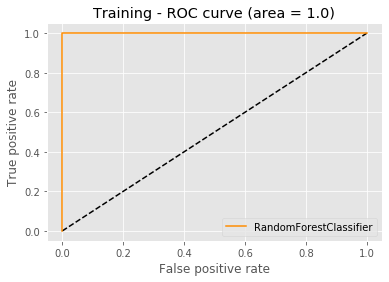

[[ 78   0]
 [  0 280]]

accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
auc...................... 1.0000
F1 macro................. 1.0000
F1 micro................. 1.0000
F1 weighted.............. 1.0000
F1 binary................ 1.0000


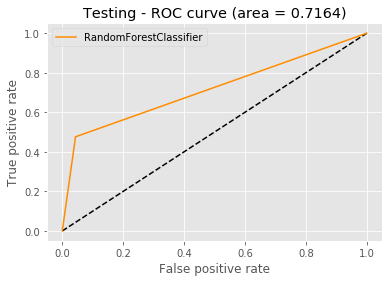

[[10 11]
 [ 3 66]]

accuracy................. 0.8444
precision................ 0.8571
recall................... 0.9565
auc...................... 0.7164
F1 macro................. 0.7462
F1 micro................. 0.8444
F1 weighted.............. 0.8304
F1 binary................ 0.5882


In [15]:
model = train_random_forest(_x, 'canceled')

In [17]:
importances = pd.Series(model.feature_importances_, index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
32,time_window,0.081748
2,avg_daily_actions,0.062306
4,n_actions,0.062071
13,n_home,0.053749
14,n_likes,0.045794
30,session_avg_songs,0.045733
17,n_songs,0.044071
19,session_avg_actions,0.042785
28,session_avg_playback,0.038420
15,n_sess,0.036981


## Gradient Boosting

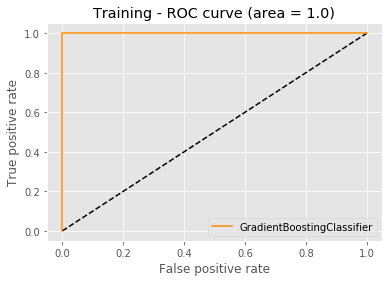

[[ 78   0]
 [  0 280]]

accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
auc...................... 1.0000
F1 macro................. 1.0000
F1 micro................. 1.0000
F1 weighted.............. 1.0000
F1 binary................ 1.0000


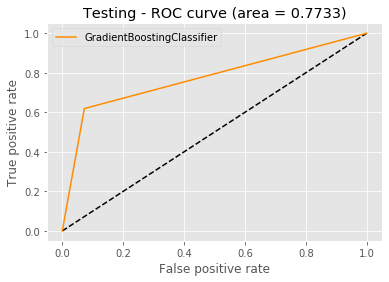

[[13  8]
 [ 5 64]]

accuracy................. 0.8556
precision................ 0.8889
recall................... 0.9275
auc...................... 0.7733
F1 macro................. 0.7872
F1 micro................. 0.8556
F1 weighted.............. 0.8515
F1 binary................ 0.6667


In [18]:
model = train_gradient_boosting(_x, 'canceled')

In [20]:
importances = pd.Series(model.feature_importances_, index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
6,n_ads,0.139794
29,session_avg_settings,0.101757
32,time_window,0.080774
28,session_avg_playback,0.074216
4,n_actions,0.059921
2,avg_daily_actions,0.059165
31,session_avg_time_away,0.046500
11,n_friends,0.041863
13,n_home,0.040856
19,session_avg_actions,0.039821


## Logistic Regression

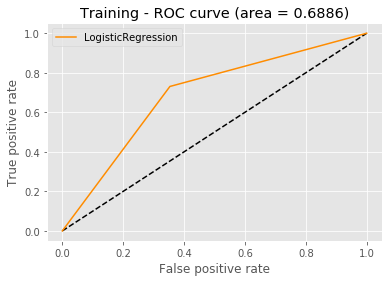

[[ 57  21]
 [ 99 181]]

accuracy................. 0.6648
precision................ 0.8960
recall................... 0.6464
auc...................... 0.6886
F1 macro................. 0.6191
F1 micro................. 0.6648
F1 weighted.............. 0.6935
F1 binary................ 0.4872


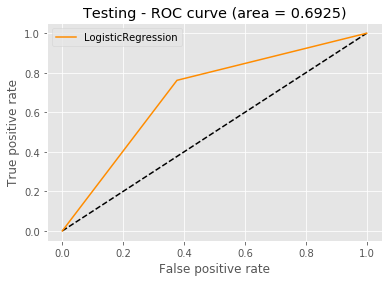

[[16  5]
 [26 43]]

accuracy................. 0.6556
precision................ 0.8958
recall................... 0.6232
auc...................... 0.6925
F1 macro................. 0.6215
F1 micro................. 0.6556
F1 weighted.............. 0.6821
F1 binary................ 0.5079


In [21]:
model = train_logistic_regression(_x, 'canceled')

In [28]:
importances = pd.Series(list(model.coef_[0]), index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
4,n_actions,2.035683
2,avg_daily_actions,1.280831
6,n_ads,0.757585
31,session_avg_time_away,0.742954
17,n_songs,0.626736
13,n_home,0.189430
21,session_avg_ads,0.152094
0,male,0.142240
3,avg_session_duration,0.134081
15,n_sess,0.104755


## ExtraTreesClassifier

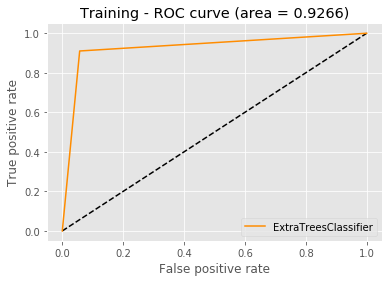

[[ 71   7]
 [ 16 264]]

accuracy................. 0.9358
precision................ 0.9742
recall................... 0.9429
auc...................... 0.9266
F1 macro................. 0.9094
F1 micro................. 0.9358
F1 weighted.............. 0.9370
F1 binary................ 0.8606


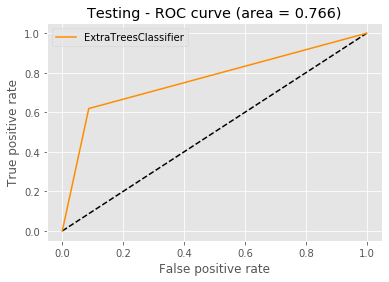

[[13  8]
 [ 6 63]]

accuracy................. 0.8444
precision................ 0.8873
recall................... 0.9130
auc...................... 0.7660
F1 macro................. 0.7750
F1 micro................. 0.8444
F1 weighted.............. 0.8417
F1 binary................ 0.6500


In [36]:
model = train_extra_trees_classifier(_x, 'canceled')

In [37]:
importances = pd.Series(model.feature_importances_, index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
32,time_window,0.099201
4,n_actions,0.084081
6,n_ads,0.062845
17,n_songs,0.053066
16,n_settings,0.051327
3,avg_session_duration,0.049041
2,avg_daily_actions,0.046711
13,n_home,0.035634
18,n_upgrades,0.034793
14,n_likes,0.032638


## Grid Search and Tuning

In [148]:
#dir(Normalizer().__class__)

Normalizer()

'Normalizer'

Strategy: MaxAbsScaler
Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1698 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:  2.4min finished


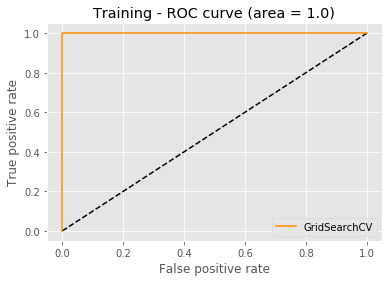

[[ 68   0]
 [  0 245]]

accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
auc...................... 1.0000
F1 macro................. 1.0000
F1 micro................. 1.0000
F1 weighted.............. 1.0000
F1 binary................ 1.0000


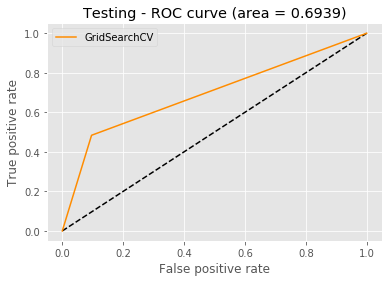

[[15 16]
 [10 94]]

accuracy................. 0.8074
precision................ 0.8545
recall................... 0.9038
auc...................... 0.6939
F1 macro................. 0.7071
F1 micro................. 0.8074
F1 weighted.............. 0.7998
F1 binary................ 0.5357


In [151]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler, MaxAbsScaler

# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

models = []

for _scaller in [MaxAbsScaler()]:# [Normalizer(), RobustScaler(), StandardScaler()]:
    
    print(f'Strategy: {_scaller.__class__.__name__}')
    
    _x = data.copy()
    _x[features_to_normalize] = _scaller.fit_transform(_x[features_to_normalize]) 
    
    model, X_test, y_test = train_gs_gradient_boosting(_x, 'canceled')
    
    models.append(model.best_estimator_)


# model, X_test, y_test = train_gs_gradient_boosting(_x, 'canceled')

# best_model = model.best_estimator_

# y_predicted = model.predict(X_test)
# plot_roc_curve(y_test, y_predicted, model, 'Testing')
# plot_metrics(y_test, y_predicted)

In [140]:
importances = pd.Series(best_model.feature_importances_, index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
6,n_ads,0.113594
32,time_window,0.104322
4,n_actions,0.090916
18,n_upgrades,0.084942
15,n_sess,0.064454
14,n_likes,0.049799
22,session_avg_dislikes,0.044507
29,session_avg_settings,0.043973
2,avg_daily_actions,0.040238
17,n_songs,0.036719


Fitting 5 folds for each of 3750 candidates, totalling 18750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5997 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6669 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7405 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8205 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9069 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 9997 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 10989 tasks     

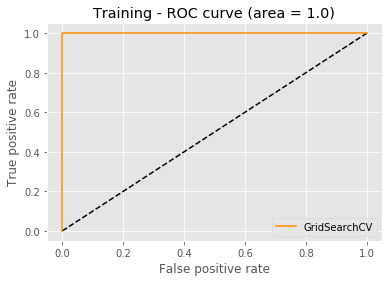

[[ 68   0]
 [  0 245]]

accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
auc...................... 1.0000
F1 macro................. 1.0000
F1 micro................. 1.0000
F1 weighted.............. 1.0000
F1 binary................ 1.0000


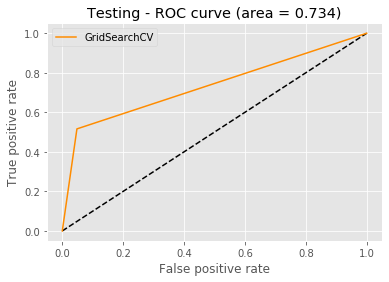

[[16 15]
 [ 5 99]]

accuracy................. 0.8519
precision................ 0.8684
recall................... 0.9519
auc...................... 0.7340
F1 macro................. 0.7618
F1 micro................. 0.8519
F1 weighted.............. 0.8410
F1 binary................ 0.6154


In [156]:
model, X_test, y_test = train_gs_gradient_boosting(_x, 'canceled')

best_model = model.best_estimator_

# y_predicted = model.predict(X_test)
# plot_roc_curve(y_test, y_predicted, model, 'Testing')
# plot_metrics(y_test, y_predicted)